
# Project: Investigate a Dataset - [Amazon_product_data]

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#question">Questions</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
<li><a href="#limit">Limitation</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 


#### Dataset Overview
<ul>
<li>This dataset contains information about 10,000 movies collected from the Movie Database (TMDb).</li>
<li>The dataset includes user ratings and revenue information for each movie.</li>
<li>Certain columns, such as 'cast' and 'genres', contain multiple values separated by pipe (|) characters. These columns likely list the cast and genres associated with each movie.</li>
<li>The 'cast' column may contain odd characters, and it's mentioned that there is no need to clean them.</li>
</ul>

#### Columns in the Dataset:
1. `product_id`: A unique identifier for each product.
2. `product_name`: Name of the Product.
3. `category`: Category of the Product.
4. `discounted_price`: Discounted Price of the Product.
5. `actual_price`: Actual Price of the Product.
6. `discount_percentage`: Percentage of Discount for the Product.
7. `rating`: Rating of the Product.
8. `rating_count`: Number of people who voted for the Amazon rating.
9. `about_product`: Description about the Product.
10. `user_id`: ID of the user who wrote review for the Product.
11. `user_name`: Name of the user who wrote review for the Product.
12. `review_id`: ID of the user review.
13. `review_title`: Short review.
14. `review_content`: Long review.
15. `img_link`: Image Link of the Product.
16. `product_link`: Official Website Link of the Product

<a id='question'></a>
## Question(s) for Analysis
1. Are higher discount percentages are associated with lower product ratings?
- This question determine whether products offerd at higher discounts tend to have lower rating. 
- It leads to shows that discounted items maybe perceived as lower quality or less desirable.
- This relationship will identify optimal discount levels that do not negatively impact product perception.
2. Do products with more reviews have higher average ratings?
- This hypothesis investigates if products with higher number of reviews tend to have higher rating.
- It determine if popular items receive better feedback.
3. Do higher-priced products receive better ratings than lower-priced ones?
- Consumers might have higher expectations for premium products, so it’s interesting to see if higher-priced products actually receive better ratings. Testing this hypothesis can reveal if price influences customer perception positively or if lower-priced products perform equally well in terms of customer satisfaction.
4. Do Products with Positive Sentiment in Reviews Have Higher Ratings?
- This hypothesis examines whether the sentiment expressed in customer reviews (positive, neutral, or negative) aligns with the product’s rating. If confirmed, this could suggest that sentiment analysis can serve as a proxy for predicting overall product satisfaction and help brands understand customer sentiment trends.
5. Which Categories of Products Receive the Highest or Lowest Ratings?
- Different product categories (like Electronics, Home & Kitchen) may naturally attract different rating distributions due to factors such as user expectations and product complexity. This hypothesis will help identify if certain categories are more favorably rated, providing insights into customer satisfaction by category.

In [1]:
# import numpy, pandas, matplotlib, and seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import seaborn as sns
import nltk
from scipy import stats
import plotly.io as pio
pio.renderers.default='notebook'
%matplotlib inline

In [2]:
# Upgrade pandas to use dataframe.explode() function. 
#!pip install --upgrade pandas==0.25.1

<a id='wrangling'></a>
## Data Wrangling

### Initial Cleaning

In [3]:
# load datasets from amazon.csv file
df = pd.read_csv("data/amazon.csv")

In [4]:
#Create a temp dataset named df2
df2 = df.copy()

In [5]:
# view the first 5 rows of the dataset
df.head()

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
0,B07JW9H4J1,Wayona Nylon Braided USB to Lightning Fast Cha...,Computers&Accessories|Accessories&Peripherals|...,₹399,"₹1,099",64%,4.2,"24,269",High Compatibility : Compatible With iPhone 12...,"AG3D6O4STAQKAY2UVGEUV46KN35Q,AHMY5CWJMMK5BJRBB...","Manav,Adarsh gupta,Sundeep,S.Sayeed Ahmed,jasp...","R3HXWT0LRP0NMF,R2AJM3LFTLZHFO,R6AQJGUP6P86,R1K...","Satisfied,Charging is really fast,Value for mo...",Looks durable Charging is fine tooNo complains...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
1,B098NS6PVG,Ambrane Unbreakable 60W / 3A Fast Charging 1.5...,Computers&Accessories|Accessories&Peripherals|...,₹199,₹349,43%,4.0,"43,994","Compatible with all Type C enabled devices, be...","AECPFYFQVRUWC3KGNLJIOREFP5LQ,AGYYVPDD7YG7FYNBX...","ArdKn,Nirbhay kumar,Sagar Viswanathan,Asp,Plac...","RGIQEG07R9HS2,R1SMWZQ86XIN8U,R2J3Y1WL29GWDE,RY...","A Good Braided Cable for Your Type C Device,Go...",I ordered this cable to connect my phone to An...,https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Ambrane-Unbreakable-Char...
2,B096MSW6CT,Sounce Fast Phone Charging Cable & Data Sync U...,Computers&Accessories|Accessories&Peripherals|...,₹199,"₹1,899",90%,3.9,"7,928",【 Fast Charger& Data Sync】-With built-in safet...,"AGU3BBQ2V2DDAMOAKGFAWDDQ6QHA,AESFLDV2PT363T2AQ...","Kunal,Himanshu,viswanath,sai niharka,saqib mal...","R3J3EQQ9TZI5ZJ,R3E7WBGK7ID0KV,RWU79XKQ6I1QF,R2...","Good speed for earlier versions,Good Product,W...","Not quite durable and sturdy,https://m.media-a...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Sounce-iPhone-Charging-C...
3,B08HDJ86NZ,boAt Deuce USB 300 2 in 1 Type-C & Micro USB S...,Computers&Accessories|Accessories&Peripherals|...,₹329,₹699,53%,4.2,"94,363",The boAt Deuce USB 300 2 in 1 cable is compati...,"AEWAZDZZJLQUYVOVGBEUKSLXHQ5A,AG5HTSFRRE6NL3M5S...","Omkar dhale,JD,HEMALATHA,Ajwadh a.,amar singh ...","R3EEUZKKK9J36I,R3HJVYCLYOY554,REDECAZ7AMPQC,R1...","Good product,Good one,Nice,Really nice product...","Good product,long wire,Charges good,Nice,I bou...",https://m.media-amazon.com/images/I/41V5FtEWPk...,https://www.amazon.in/Deuce-300-Resistant-Tang...
4,B08CF3B7N1,Portronics Konnect L 1.2M Fast Charging 3A 8 P...,Computers&Accessories|Accessories&Peripherals|...,₹154,₹399,61%,4.2,"16,905",[CHARGE & SYNC FUNCTION]- This cable comes wit...,"AE3Q6KSUK5P75D5HFYHCRAOLODSA,AFUGIFH5ZAFXRDSZH...","rahuls6099,Swasat Borah,Ajay Wadke,Pranali,RVK...","R1BP4L2HH9TFUP,R16PVJEXKV6QZS,R2UPDB81N66T4P,R...","As good as original,Decent,Good one for second...","Bought this instead of original apple, does th...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Portronics-Konnect-POR-1...


In [6]:
#view dimensions of dataset
df.shape

(1465, 16)

The number of samples in the dataset is 1465, The number of columns in the dataset is 16

In [7]:
#explore the dataset, checking for the missing value of each column.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_id           1465 non-null   object
 1   product_name         1465 non-null   object
 2   category             1465 non-null   object
 3   discounted_price     1465 non-null   object
 4   actual_price         1465 non-null   object
 5   discount_percentage  1465 non-null   object
 6   rating               1465 non-null   object
 7   rating_count         1463 non-null   object
 8   about_product        1465 non-null   object
 9   user_id              1465 non-null   object
 10  user_name            1465 non-null   object
 11  review_id            1465 non-null   object
 12  review_title         1465 non-null   object
 13  review_content       1465 non-null   object
 14  img_link             1465 non-null   object
 15  product_link         1465 non-null   object
dtypes: obj

There is no null data in this dataset.

In [8]:
#view the datatype of each column
df.dtypes

product_id             object
product_name           object
category               object
discounted_price       object
actual_price           object
discount_percentage    object
rating                 object
rating_count           object
about_product          object
user_id                object
user_name              object
review_id              object
review_title           object
review_content         object
img_link               object
product_link           object
dtype: object

In [9]:
#Show how many unique values are there in each columns.
df.nunique()

product_id             1351
product_name           1337
category                211
discounted_price        550
actual_price            449
discount_percentage      92
rating                   28
rating_count           1143
about_product          1293
user_id                1194
user_name              1194
review_id              1194
review_title           1194
review_content         1212
img_link               1412
product_link           1465
dtype: int64

In [10]:
#check whether the dataset has duplicated row
sum(df.duplicated())

0

There is 0 duplicate row in the dataset

In [11]:
#show the null rows in each column
df.isnull().sum()

product_id             0
product_name           0
category               0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           2
about_product          0
user_id                0
user_name              0
review_id              0
review_title           0
review_content         0
img_link               0
product_link           0
dtype: int64

In [12]:
#view the overall information of the dataset:
df.describe()

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
count,1465,1465,1465,1465,1465,1465,1465,1463,1465,1465,1465,1465,1465,1465,1465,1465
unique,1351,1337,211,550,449,92,28,1143,1293,1194,1194,1194,1194,1212,1412,1465
top,B07JW9H4J1,"Fire-Boltt Ninja Call Pro Plus 1.83"" Smart Wat...",Computers&Accessories|Accessories&Peripherals|...,₹199,₹999,50%,4.1,"9,378",[CHARGE & SYNC FUNCTION]- This cable comes wit...,"AHIKJUDTVJ4T6DV6IUGFYZ5LXMPA,AE55KTFVNXYFD5FPY...","$@|\|TO$|-|,Sethu madhav,Akash Thakur,Burger P...","R3F4T5TRYPTMIG,R3DQIEC603E7AY,R1O4Z15FD40PV5,R...","Worked on iPhone 7 and didn’t work on XR,Good ...","I am not big on camera usage, personally. I wa...",https://m.media-amazon.com/images/I/413sCRKobN...,https://www.amazon.in/Wayona-Braided-WN3LG1-Sy...
freq,3,5,233,53,120,56,244,9,6,10,10,10,10,8,3,1


In [13]:
df.rating.value_counts()

4.1    244
4.3    230
4.2    228
4.0    129
3.9    123
4.4    123
3.8     86
4.5     75
4       52
3.7     42
3.6     35
3.5     26
4.6     17
3.3     16
3.4     10
4.7      6
3.1      4
5.0      3
3.0      3
4.8      3
3.2      2
2.8      2
2.3      1
|        1
2        1
3        1
2.6      1
2.9      1
Name: rating, dtype: int64

`Rating` column has 1 row that contain '|' symbol

### Fixing `rating` Column

In [14]:
# General look in rows contain '|' symbol
df2[df2['rating'] =='|']

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,user_id,user_name,review_id,review_title,review_content,img_link,product_link
1279,B08L12N5H1,Eureka Forbes car Vac 100 Watts Powerful Sucti...,"Home&Kitchen|Kitchen&HomeAppliances|Vacuum,Cle...","₹2,099","₹2,499",16%,|,992,No Installation is provided for this product|1...,"AGTDSNT2FKVYEPDPXAA673AIS44A,AER2XFSWNN4LAUCJ5...","Divya,Dr Nefario,Deekshith,Preeti,Prasanth R,P...","R2KKTKM4M9RDVJ,R1O692MZOBTE79,R2WRSEWL56SOS4,R...","Decent product,doesn't pick up sand,Ok ok,Must...","Does the job well,doesn't work on sand. though...",https://m.media-amazon.com/images/W/WEBP_40237...,https://www.amazon.in/Eureka-Forbes-Vacuum-Cle...


I checked the product_linke of "B08L12N5H1", the rating is 3.9, so I will fill the rating at 3.9

In [15]:
df.loc[df['product_id'] == 'B08L12N5H1', 'rating'] = '3.9'

### Drop extraneous columns
Columns to Drop: `img_link` , `user_name` , `user_id`

In [16]:
#drop columns from the dataset
df.drop(['img_link','user_name','user_id'], inplace=True, axis=1)

In [17]:
#confirm the changes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1465 entries, 0 to 1464
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   product_id           1465 non-null   object
 1   product_name         1465 non-null   object
 2   category             1465 non-null   object
 3   discounted_price     1465 non-null   object
 4   actual_price         1465 non-null   object
 5   discount_percentage  1465 non-null   object
 6   rating               1465 non-null   object
 7   rating_count         1463 non-null   object
 8   about_product        1465 non-null   object
 9   review_id            1465 non-null   object
 10  review_title         1465 non-null   object
 11  review_content       1465 non-null   object
 12  product_link         1465 non-null   object
dtypes: object(13)
memory usage: 148.9+ KB


### Dedupe Data

In [18]:
#print number of duplicates to confirm dedupe - should be 0
print(df.duplicated().sum())

0


### Drop Rows with Missing Values

In [19]:
# view missing value count for each property
df.isnull().sum()

product_id             0
product_name           0
category               0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           2
about_product          0
review_id              0
review_title           0
review_content         0
product_link           0
dtype: int64

In [20]:
df[df['rating_count'].isnull()]

,product_id,product_name,category,discounted_price,actual_price,discount_percentage,rating,rating_count,about_product,review_id,review_title,review_content,product_link
282,B0B94JPY2N,Amazon Brand - Solimo 65W Fast Charging Braide...,Computers&Accessories|Accessories&Peripherals|...,₹199,₹999,80%,3.0,NaN,USB C to C Cable: This cable has type C connec...,RUB7U91HVZ30,The cable works but is not 65W as advertised,I have a pd supported car charger and I bought...,https://www.amazon.in/Amazon-Brand-Charging-Su...
324,B0BQRJ3C47,"REDTECH USB-C to Lightning Cable 3.3FT, [Apple...",Computers&Accessories|Accessories&Peripherals|...,₹249,₹999,75%,5.0,NaN,💎[The Fastest Charge] - This iPhone USB C cabl...,RQXD5SAMMPC6L,Awesome Product,Quick delivery.Awesome ProductPacking was good...,https://www.amazon.in/REDTECH-Lightning-Certif...


I go to product link to check and notice that product_id: B0B94JPY2N has 4.0 rating and 58 rating_count. 
Product_id B0BQRJ3C47 hasn't existed in amazon so I will drop it.

In [21]:
df[df['rating_count'].isnull()].product_link

282    https://www.amazon.in/Amazon-Brand-Charging-Su...
324    https://www.amazon.in/REDTECH-Lightning-Certif...
Name: product_link, dtype: object

In [22]:
df.loc[df['product_id'] == 'B0B94JPY2N', 'rating_count'] = '58'
df.loc[df['product_id'] == 'B0B94JPY2N', 'rating'] = '4.0'

In [23]:
#drop rows with any null values in dataset
df.dropna(inplace=True)

In [24]:
# checks if any of columns in the dataset have null values - should print False
df.isnull().sum().any()

False

### Data Transformation

Create a float_change function to automatically change float type to each column.

In [25]:
def convert_to_float(df,column_name):
    # removes any non-numeric characters (except for the decimal point)
    df[column_name] = df[column_name].str.replace(r'[^0-9.]', '', regex=True)
    
    # convert string to float for actual_price column
    df[column_name] = df[column_name].astype(float)

Convert price-related columns to floats for easier calculations

In [26]:
# convert string to float for discounted_price column
convert_to_float(df,'discounted_price')

In [27]:
# convert string to float for actual_price column
convert_to_float(df,'actual_price')

In [28]:
# convert string to float for rating_count column
convert_to_float(df,"rating_count")

In [29]:
# convert string to float for rating column
convert_to_float(df,"rating")

In [30]:
# Handle the 'discount_percentage' column by converting it to a decimal value (0–1 range)
df['discount_percentage'] = df['discount_percentage'].str.replace('%', '').astype(float) / 100

In [31]:
# check data type for revenue column and budget column
df.dtypes

product_id              object
product_name            object
category                object
discounted_price       float64
actual_price           float64
discount_percentage    float64
rating                 float64
rating_count           float64
about_product           object
review_id               object
review_title            object
review_content          object
product_link            object
dtype: object

In [32]:
df.isnull().sum()

product_id             0
product_name           0
category               0
discounted_price       0
actual_price           0
discount_percentage    0
rating                 0
rating_count           0
about_product          0
review_id              0
review_title           0
review_content         0
product_link           0
dtype: int64

### Feature Creating

Create a split_and_expand function to automatically split and expand into separate rows.

In [33]:
# Split the 'category' column into two parts: general category and product type
def split_category(df, column_name, fill_value='NaN'):
    # split the specified column on the delimiter '|'
    # expand=True: instead of storing lists in a single column,
    # it creates multiple columns in the resulting DataFrame category_split
    
    split_column = df[column_name].str.split('|', expand=True) 
    
    # Create new column named main_category
    df['main_category'] = split_column[0]
    
    # Create new column named product_type
    df['product_type'] = split_column[1]
    
    #drop the old columns
    df.drop(columns=[column_name], inplace=True)

Call split_category function to split category column

In [34]:
# Appply the function to 'category' column
split_category(df, 'category')

In [35]:
# Using the median price to split the products
median_price = df['discounted_price'].median()
df['price_category'] = df['discounted_price'].apply(lambda x: 'Lower-Priced' if x < median_price else 'Higher-Priced')

Function to get sentiment

In [36]:
# Initialize VADER SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

In [37]:
# Function to get sentiment
def get_vader_sentiment(text):
    score = sia.polarity_scores(text)
    return score['compound']  # compound score between -1 (negative) and 1 (positive)

In [38]:
# Applying sentiment analysis
df['vader_sentiment_score'] = df['review_content'].apply(get_vader_sentiment)
df['vader_sentiment'] = df['vader_sentiment_score'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))

In [39]:
df['vader_sentiment'].value_counts()

Positive    1381
Negative      80
Neutral        3
Name: vader_sentiment, dtype: int64

In [40]:
#Confirm the new columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1464 entries, 0 to 1464
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   product_id             1464 non-null   object 
 1   product_name           1464 non-null   object 
 2   discounted_price       1464 non-null   float64
 3   actual_price           1464 non-null   float64
 4   discount_percentage    1464 non-null   float64
 5   rating                 1464 non-null   float64
 6   rating_count           1464 non-null   float64
 7   about_product          1464 non-null   object 
 8   review_id              1464 non-null   object 
 9   review_title           1464 non-null   object 
 10  review_content         1464 non-null   object 
 11  product_link           1464 non-null   object 
 12  main_category          1464 non-null   object 
 13  product_type           1464 non-null   object 
 14  price_category         1464 non-null   object 
 15  vade

<a id='eda'></a>
## Exploratory Data Analysis


### Research Question 1: Is there a relationship between discount percentage and average product rating ?

**Analysis Decision 1**: Bin the discount percentage data

In [41]:
bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
labels = ['0-10%', '10-20%', '20-30%', '30-40%', '40-50%', '50-60%', '60-70%', '70-80%', '80-90%', '90-100%']
df['discount_bin'] = pd.cut(df['discount_percentage'], bins=bins, labels=labels)

**Reasoning**: Provids a simplified distribution and can make comparisons easier.

**Analysis Decision 2**: Draw histogram to describe distribution of discount percentage.

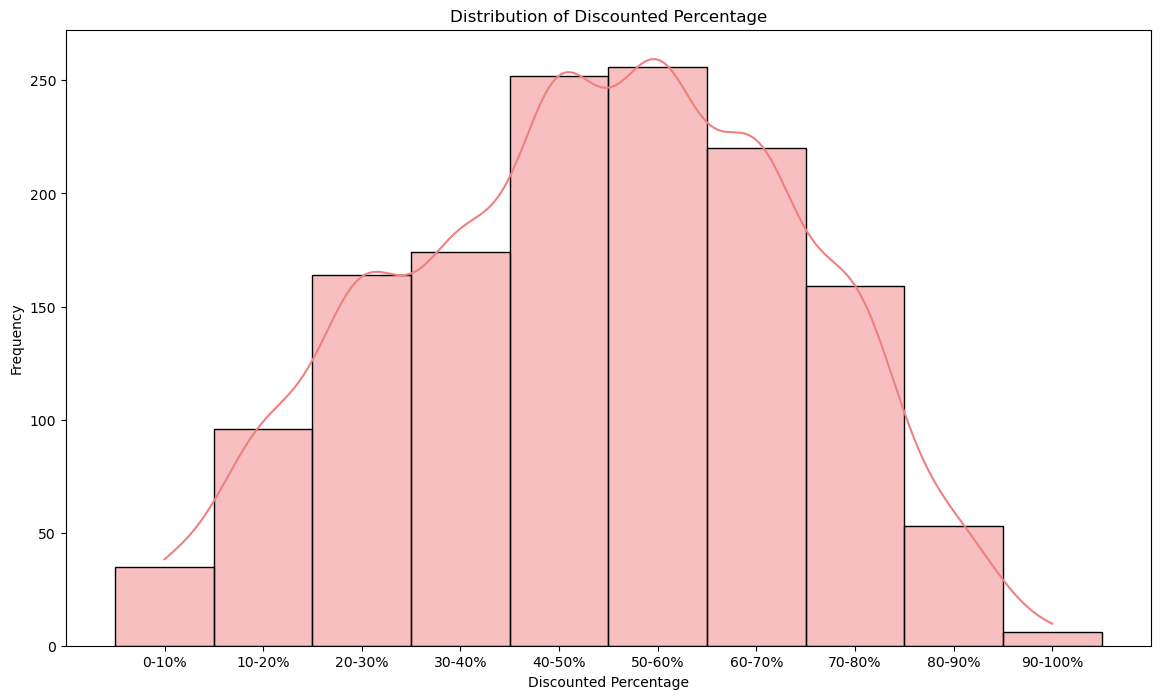

In [82]:
plt.figure(figsize=(14, 8))
sns.histplot(df['discount_bin'], kde=True, color='lightcoral')
plt.title('Distribution of Discounted Percentage')
plt.xlabel('Discounted Percentage')
plt.ylabel('Frequency')
plt.show()

**Reasoning**: This histogram plot will help us understand how pricing stategies are distributed and potential impact on consumer behavior and busisness performance.

**Summary**: 
- The peak around 40% to 60% discount.
- Discounts greater than 80% are rare.
- Very few products are offered without any discount.
- Most products are offered with moderate to high discounts, with a few products available at no discount or very high discounts.

**Analysis Decision 3**: Rating

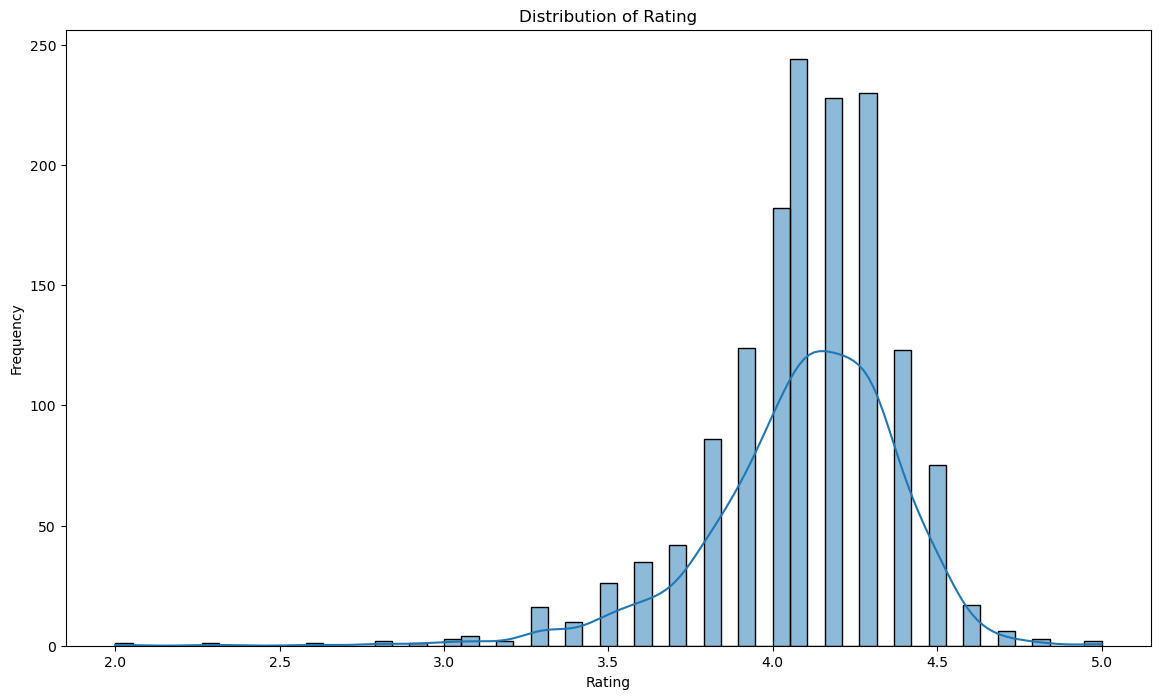

In [43]:
plt.figure(figsize=(14, 8))
sns.histplot(df['rating'], kde=True)
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

**Reasoning**: This histogram plot will help us understand how pricing stategies are distributed and potential impact on consumer behavior and busisness performance.

**Summary**: 
- The majority of ratings seem to cluster betwen 3.5 and 4.5, indicating that most products are rated positively.
- Very few ratings are below 3.0, suggesting that poor ratings are rare in this dataset

In [44]:
#Calculate the correlation number between vote_count and Revenue
df['discount_percentage'].corr(df['rating'])

-0.15507651849573378

**Summary**: 
- The correlation between discount percentage and rating is -0.155, it shows a weak negative relationship. This implies that in general, when the product rating decreases, the discount percentage will be increases, though the effect is minimal.

**Analysis Decision 4**: Relationship between rating and discount percentage

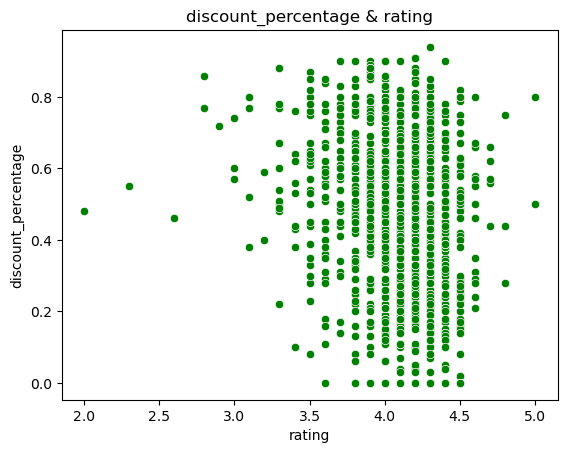

In [45]:
sns.scatterplot(x='rating',y='discount_percentage', data= df, color = "green")
plt.title("discount_percentage & rating")
plt.show()

**Reasoning**: This scatter plot will help us understand whether higher rating engagement leads to higher discount percentage

**Summary**:
- The scatter plot shows a very slight downward trend, but it is difficult to tell.

**Analysis Decision 5**: Grouping Rating

**Reasoning**: This grouping gives a meaningful breakdown, because the ratings are mostly concentrated around certain values.

- Low Ratings (1.0 - 3.0): These are rare, but they represent a significant drop in product quality or satisfaction.
- Average Ratings (3.0 - 4.0): This range covers a moderate level of satisfaction.
- Good Ratings (4.0 - 4.5): The largest concentration falls here, representing well-rated products.
- Excellent Ratings (4.5 - 5.0): This would represent top-rated products.

In [46]:
df['mean_of_ratings'] = pd.cut(df['rating'], [1, 3, 3.5, 4, 5], labels = ['Low', 'Average', 'Good', 'Excellent'])

Visualize for the distribution of rating after group.

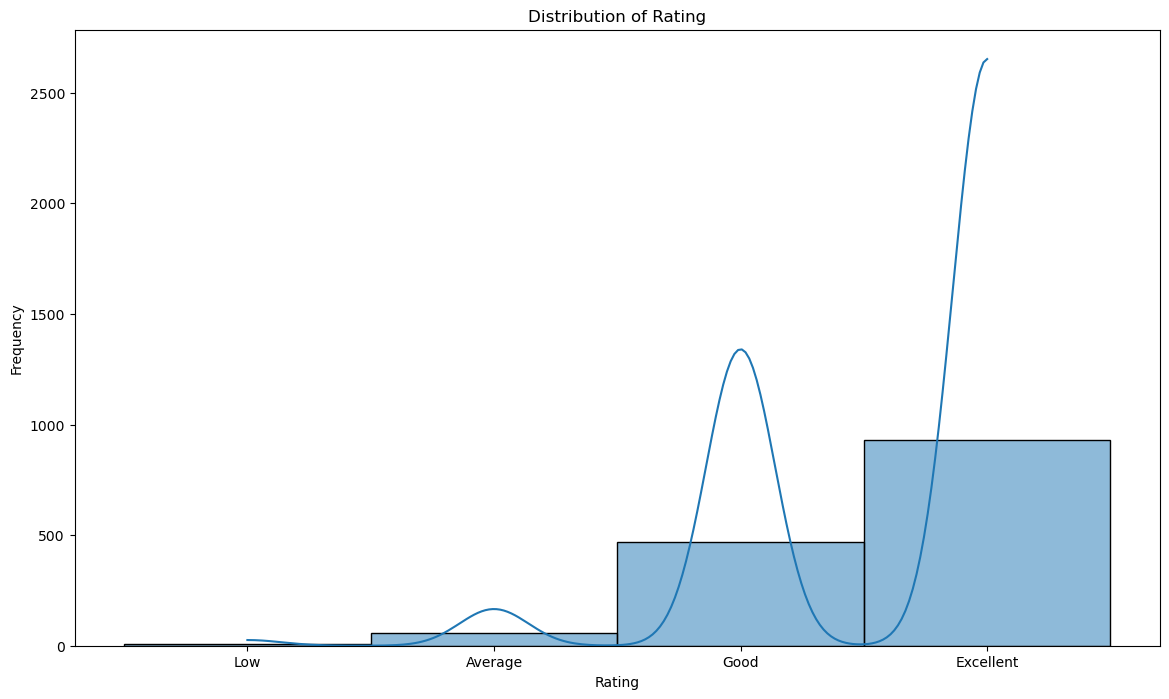

In [47]:
plt.figure(figsize=(14, 8))
sns.histplot(df['mean_of_ratings'], kde=True)
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

The plot shows that the dataset mostly give excellent rating in the product.

**Summary**:
- The scatter plot shows a very slight downward trend, but it is difficult to tell.

In [48]:
discount_vs_rating = df.groupby('mean_of_ratings')['discount_percentage'].mean()
print(discount_vs_rating)

mean_of_ratings
Low          0.638889
Average      0.563276
Good         0.507356
Excellent    0.454267
Name: discount_percentage, dtype: float64


**Summary**:
- Low-rated products have the highest average discount at 63.9%.
- Excellent-rated products have the lowest average discount at 45.4%
- This suggests that lower-rated products tend to have higher discounts.

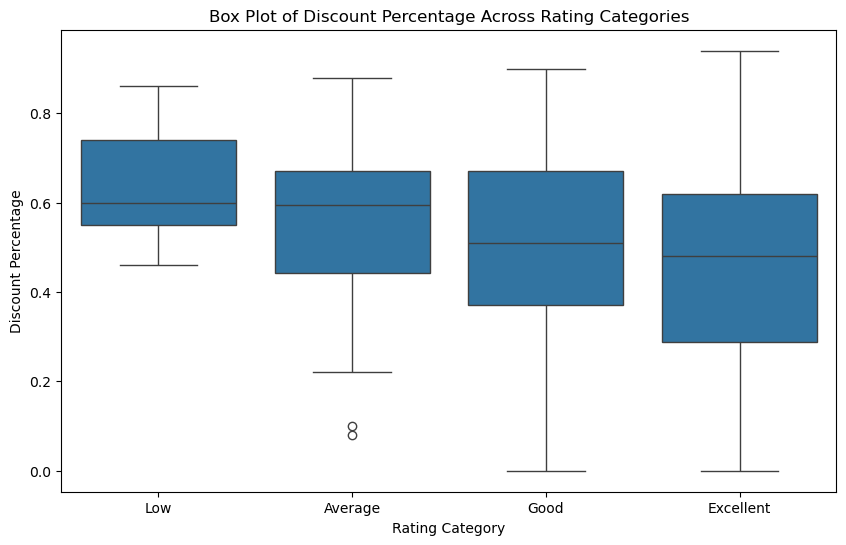

In [49]:
plt.figure(figsize=(10,6))
sns.boxplot(x='mean_of_ratings', y='discount_percentage', data=df)
plt.title('Box Plot of Discount Percentage Across Rating Categories')
plt.xlabel('Rating Category')
plt.ylabel('Discount Percentage')
plt.show()

The relationship between discount percentage and product ratings is clear:
- Products with lower ratings tend to offer higher discounts.
- Products with higher ratings offer more moderate discounts, leveraging their quality and reputation to drive sales without needing large discounts.

In [50]:
# Group by rating categories and calculate the correlation
grouped_by_rating = df.groupby('mean_of_ratings').apply(
    lambda x: x['discount_percentage'].corr(x['rating'])
)

print(grouped_by_rating)

mean_of_ratings
Low          0.548148
Average     -0.096236
Good        -0.040843
Excellent   -0.056030
dtype: float64


- Low-Rated Products: There is a moderately strong positive correlation for low-rated products. This suggests that products with low ratings are likely to offer higher discounts.
- Average, Good, and Excellent Products: For these categories, the correlation is weakly negative. This suggests that higher discounts are less commonly associated with higher-rated products. In fact, these products are more likely to maintain moderate or lower discount levels, relying on their good ratings to drive sales.

### Research Question 2:  Do products with more reviews have higher or lower average ratings?

**Analysis Decision 1**: Create review count ranges.

In [51]:
df['rating_count'].describe()

count      1464.000000
mean      18283.084016
std       42741.908537
min           2.000000
25%        1179.000000
50%        5178.500000
75%       17330.750000
max      426973.000000
Name: rating_count, dtype: float64

- The review counts range is quite wide, from 2 to 426,973 reviews.
- The mean is 18283, std is 42741 shows that the distribution is skewed.

**Analysis Decision 2**: Binning rating_count into defined groups.

In [52]:
# Step 1: Define bins for review count ranges
bins = [0, 100, 1000, 5000, 10000, 50000, 100000, 500000]  # Define the review count ranges
labels = ['0-100', '100-1000', '1000-5000', '5000-10000', '10000-50000', '50000-100000', '100000+']  # Label each range

In [53]:
# Create a new column in the DataFrame to represent review count ranges
df['rating_count_group'] = pd.cut(df['rating_count'], bins=bins, labels=labels)

**Reasoning**: This will help reduce the impact of extreme values.

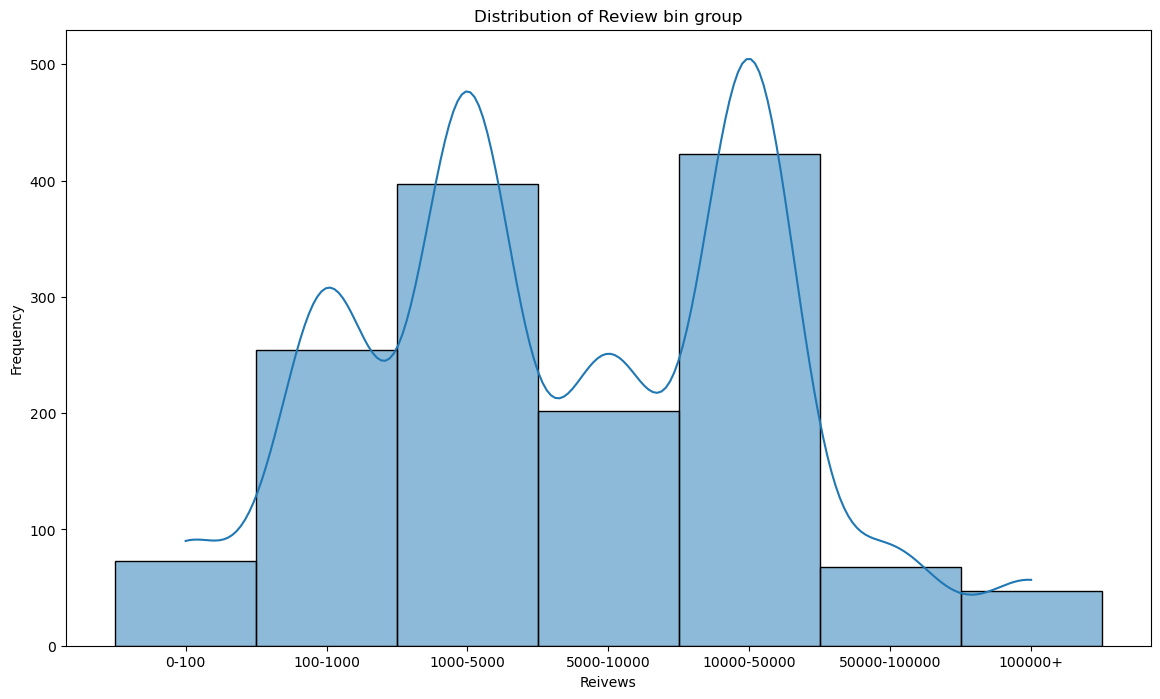

In [54]:
plt.figure(figsize=(14, 8))
sns.histplot(df['rating_count_group'], kde=True)
plt.title('Distribution of Review bin group')
plt.xlabel('Reivews')
plt.ylabel('Frequency')
plt.show()

**Summary**:
- The rating_count_group binning has provided a more balanced view of data.
- The bimodal distribution suggests that most products either have moderate (1000-5000) or high (10000-50000) review counts, with fewer products at the extremes (very low or very high review counts). This information can help guide further analyses on how review count affects product ratings, with attention to the most common review groups.

**Analysis Decision 3**: Calculate Average Ratings for Each Review Count Group

In [55]:
# Group by the review count ranges and calculate the mean rating
review_count_vs_rating = df.groupby('rating_count_group')['rating'].mean().reset_index()

In [56]:
# Display the result
print(review_count_vs_rating)

  rating_count_group    rating
0              0-100  3.924658
1           100-1000  4.005906
2          1000-5000  4.092443
3         5000-10000  4.138614
4        10000-50000  4.140662
5       50000-100000  4.195588
6            100000+  4.165957


**Reasoning**: 

**Summary**:
- The average rating generally increases with the review count, suggesting that products with more reviews tend to have slightly higher ratings. However, this increase plateaus after the 50000-100000 review group, with a slight decline in the 100000+ group.

**Analysis Decision 4**: Visualize the Relationship

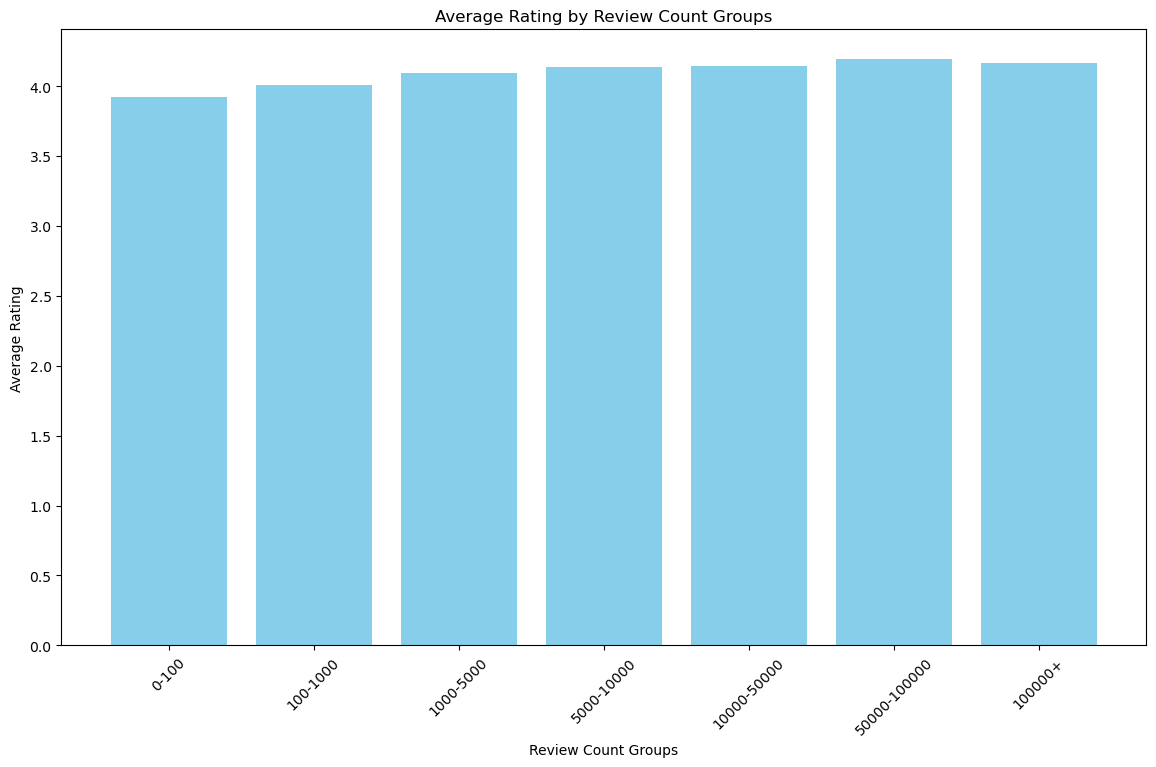

In [57]:
# Plot the relationship between review count groups and average ratings
plt.figure(figsize=(14, 8))
plt.bar(review_count_vs_rating['rating_count_group'], review_count_vs_rating['rating'], color='skyblue')
plt.xlabel('Review Count Groups')
plt.ylabel('Average Rating')
plt.title('Average Rating by Review Count Groups')
plt.xticks(rotation=45)
plt.show()

The bar plot of average ratings by review count groups confirms this trend, with a gradual rise in average rating as review count increases, peaking at 50000-100000 reviews.

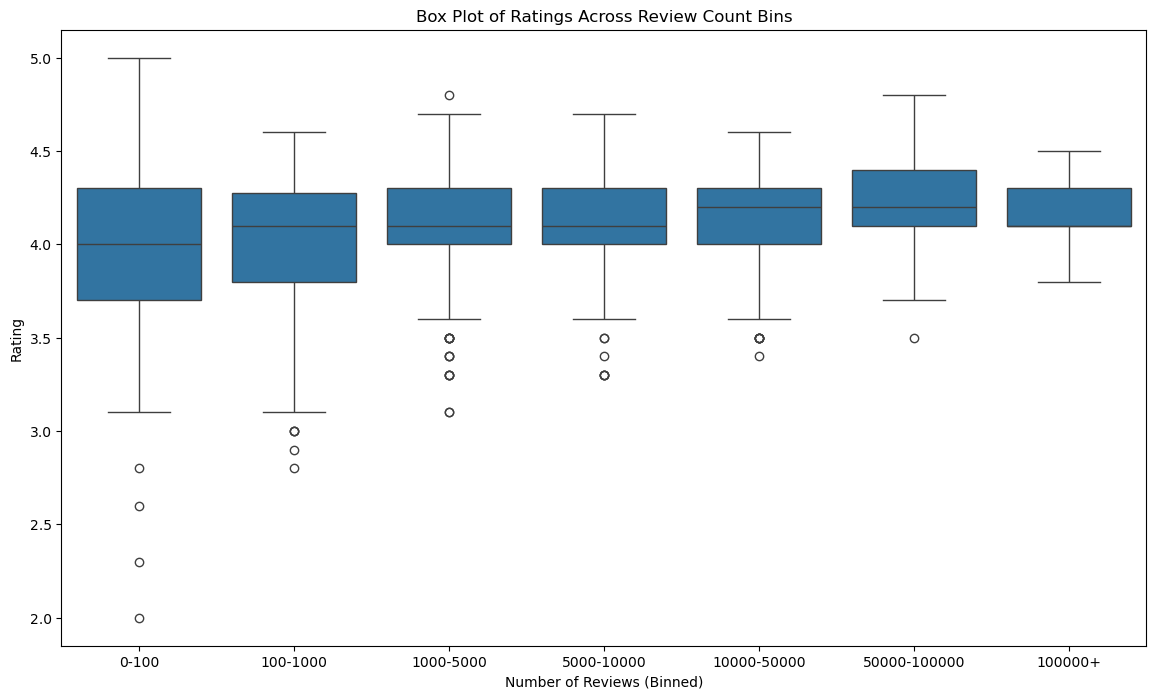

In [58]:
plt.figure(figsize=(14,8))
sns.boxplot(data=df, x='rating_count_group', y='rating')
plt.title('Box Plot of Ratings Across Review Count Bins')
plt.xlabel('Number of Reviews (Binned)')
plt.ylabel('Rating')
plt.show()

**Summary**: 
- Products with fewer reviews have more variability in their ratings (the spread is wider then higher review counts).
- Products with moderate to higher reivews are more consistent and positive in their ratings, clustering around 4.0.
- Products have 100.000+ reviews slide downward.
- All data set reamin mostly positive (above 3.5)

**Analysis Decision 5**: Correlation Analysis

In [59]:
correlation = df['rating_count'].corr(df['rating'])
print(f"Correlation between rating_count and rating: {correlation}")

Correlation between rating_count and rating: 0.10248811280168635


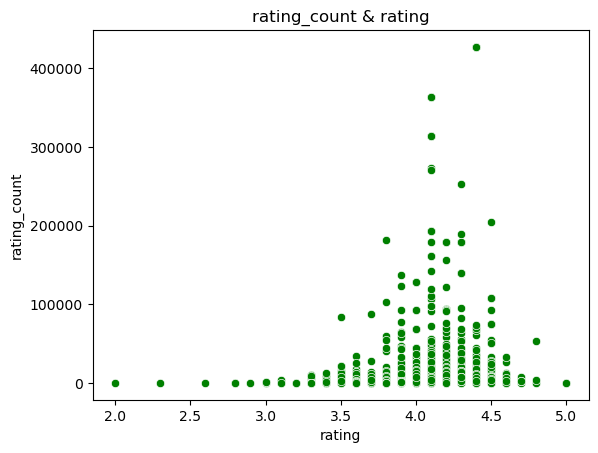

In [60]:
sns.scatterplot(x='rating',y='rating_count', data= df, color = "green")
plt.title("rating_count & rating")
plt.show()

**Summary**: 
- The correlation value of 0.102 suggests that there is a slight positive relationship between the number of reviews and its rating, but this is very weak.
- products with more reviews tend to have slightly higher ratings but the effect is minimal.

In [61]:
# Group by rating categories and calculate the correlation
grouped_by_rating = df.groupby('mean_of_ratings').apply(
    lambda x: x['rating_count'].corr(x['rating'])
)

print(grouped_by_rating)

mean_of_ratings
Low          0.604472
Average      0.211206
Good         0.135987
Excellent   -0.065201
dtype: float64


- Low-rated product has a moderate positive correlation (0.604), suggesting that among low-rated products, those with more reviews may have slightly higher ratings.
- Average-rated product has weak positive correlation (0.211).
- Good-rated product has very weak positive correlation (0.136).
- Excellent-rated product has weak negative correlation (-0.065), indicating that for top-rated products, an increase in review count does not necessarily correlate with higher ratings.

In [62]:
review_count_vs_rating = df.groupby('mean_of_ratings')['rating_count'].mean()
print(review_count_vs_rating)

mean_of_ratings
Low            199.444444
Average       5238.620690
Good         11663.014925
Excellent    22619.446121
Name: rating_count, dtype: float64


- Average review count of low-rated products is only 199, indicating that lower-rated products are generally reviewed less.
- Average review count of excellent-rated products is significantly higher at 22,619, indicating that highly-rated products tend to have more reviews, potentially reflecting greater popularity or satisfaction.

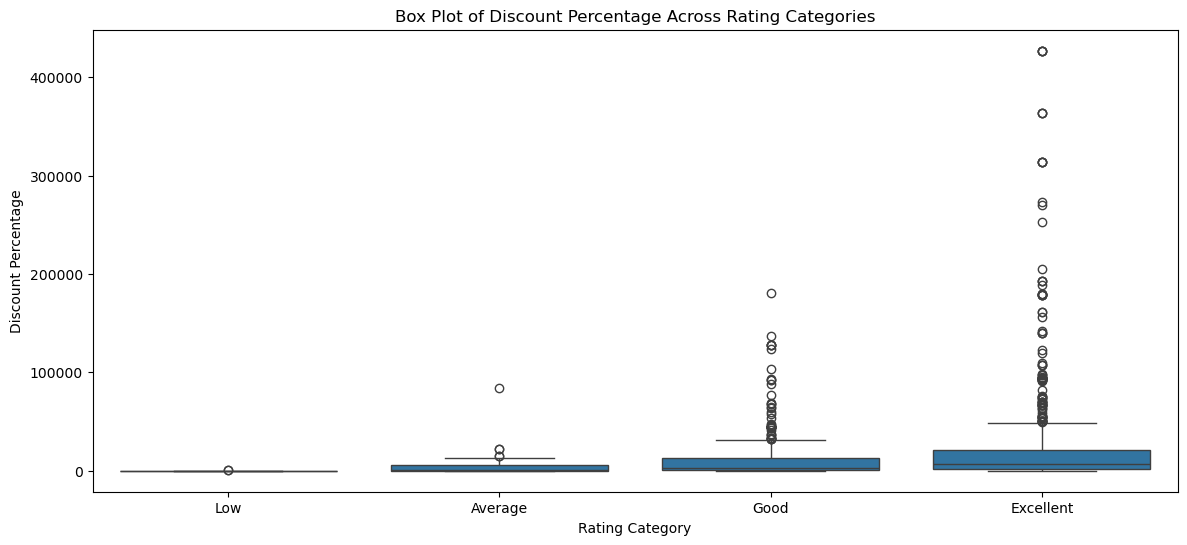

In [63]:
plt.figure(figsize=(14,6))
sns.boxplot(x='mean_of_ratings', y='rating_count', data=df)
plt.title('Box Plot of Discount Percentage Across Rating Categories')
plt.xlabel('Rating Category')
plt.ylabel('Discount Percentage')
plt.show()

### Research Question 3:  Do higher-priced products receive better ratings than lower-priced ones?

**Analysis Decision 1**: Create review count ranges.

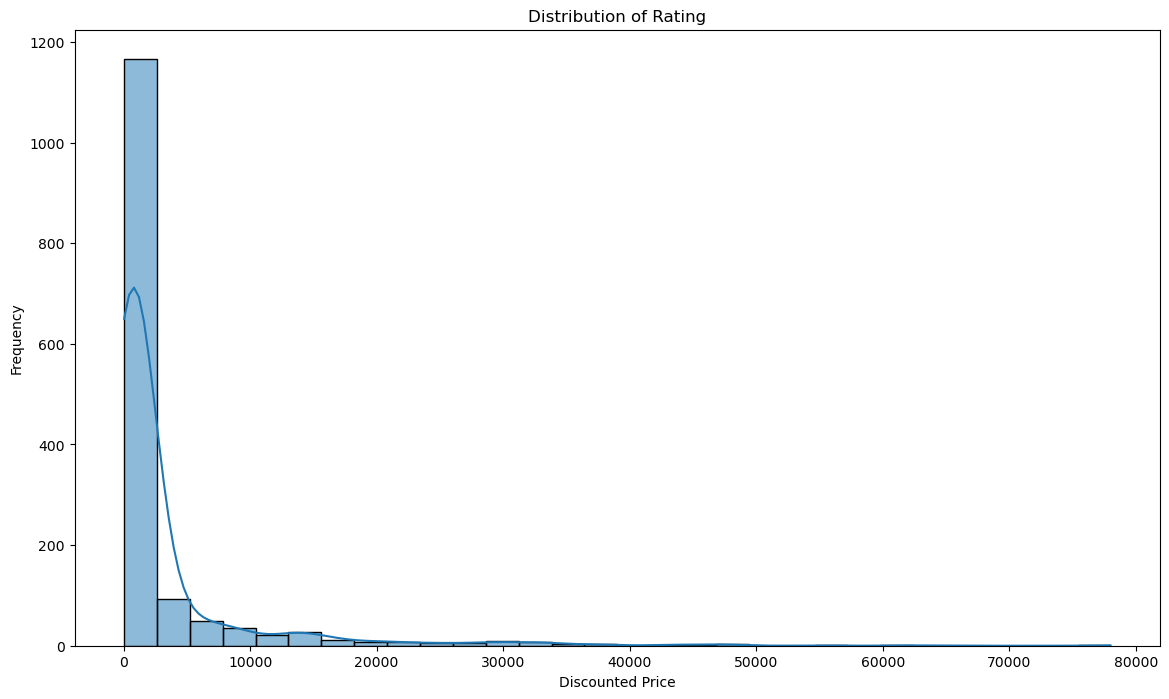

In [64]:
plt.figure(figsize=(14, 8))
sns.histplot(df['discounted_price'], bins=30, kde=True)
plt.title('Distribution of Rating')
plt.xlabel('Discounted Price')
plt.ylabel('Frequency')
plt.show()

**Analysis Decision 2**: Create review count ranges.

In [65]:
# Group by price category and calculate the mean rating
price_rating_comparison = df.groupby('price_category')['rating'].mean()
print(price_rating_comparison)

price_category
Higher-Priced    4.112064
Lower-Priced     4.080362
Name: rating, dtype: float64


- Higher-priced products (4.11) have a slightly higher average rating than lower-priced products(4.08).
- The difference is small (0.03), suggesting that price does not strongly influence rating.

In [66]:
df.groupby('price_category')['rating'].describe()

,count,mean,std,min,25%,50%,75%,max
price_category,,,,,,,,
Higher-Priced,746.0,4.112064,0.271292,2.0,4.0,4.1,4.3,4.8
Lower-Priced,718.0,4.080362,0.306356,2.3,4.0,4.1,4.3,5.0


- Both prices have a similar spread of ratings
- Higher-Priced products showing slightly less variation (lower standard deviation) than Lower-Priced products.
- This suggests that higher-priced products tend to have more consistent ratings, though the difference is minor.

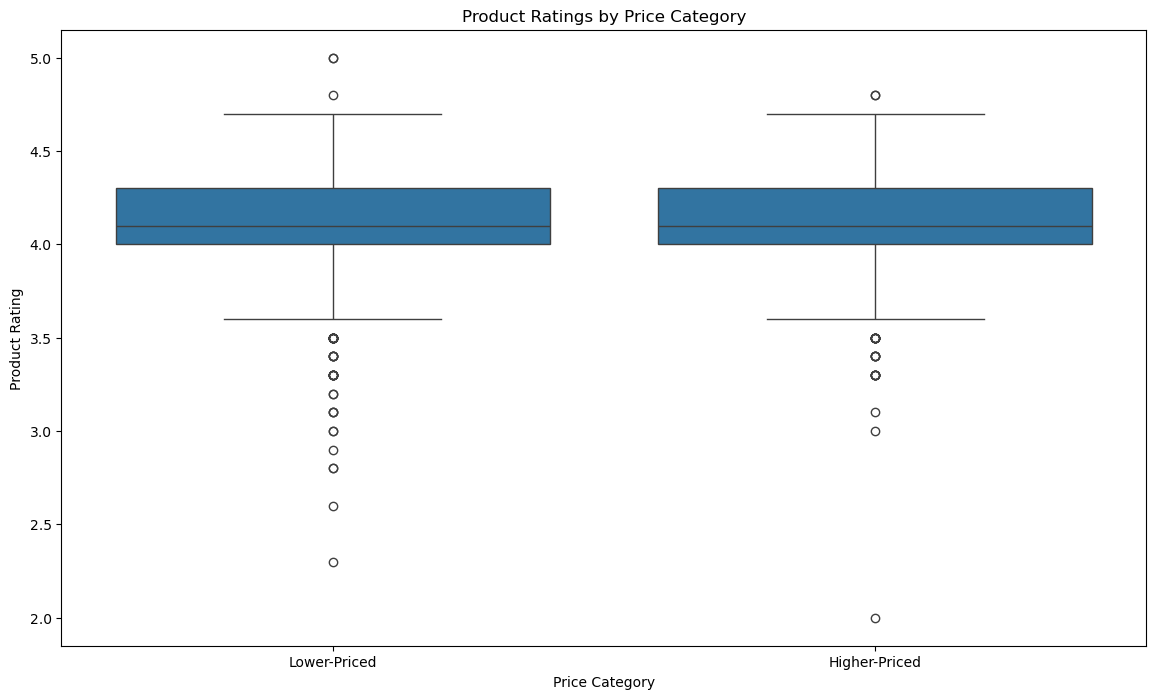

In [67]:
# Create a boxplot for ratings by price category
plt.figure(figsize=(14, 8))
sns.boxplot(x='price_category', y='rating', data=df)
plt.title('Product Ratings by Price Category')
plt.xlabel('Price Category')
plt.ylabel('Product Rating')
plt.show()

- Higher-priced products tend to receive consistently good ratings with fewer very low ratings compared to lower-priced products, which exhibit more variability in ratings and have more instances of low ratings.
- Median Rating remains the same in both price categories. It shows that customers generally rate products well regardless of price.

In [68]:
# Group by rating categories and calculate the correlation
grouped_by_rating = df.groupby('price_category').apply(
    lambda x: x['discounted_price'].corr(x['rating'])
)

print(grouped_by_rating)

price_category
Higher-Priced    0.161095
Lower-Priced     0.047617
dtype: float64


- Correlation between higher-priced products rating is 0.161, indicating a weak positive relationship between price and rating in this category.
- Correlation between lower-priced products rating is 0.048, showing an even weaker positive relationship.
- This suggests that within each group (Higher-Priced and Lower-Priced), products with higher prices tend to receive slightly better ratings, but the relationship is not strong.

### Research Question 4:  Do Products with Positive Sentiment in Reviews Have Higher Ratings ?

**Analysis Decision 1**: Group by Sentiment and Calculate the Average Rating

In [69]:
# Group by sentiment and calculate the average rating
sentiment_rating = df.groupby('vader_sentiment')['rating'].mean().reset_index()
print(sentiment_rating)

  vader_sentiment    rating
0        Negative  3.881250
1         Neutral  3.900000
2        Positive  4.109413


- Products with positive sentiment in reviews have a higher average rating compared to those with neutral or negative sentiment. 
- The difference between negative and positive sentiment ratings is about 0.23 points, which indicates a noticeable increase in rating for positively perceived products.

/tmp/ipykernel_2674/3934174626.py:4: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




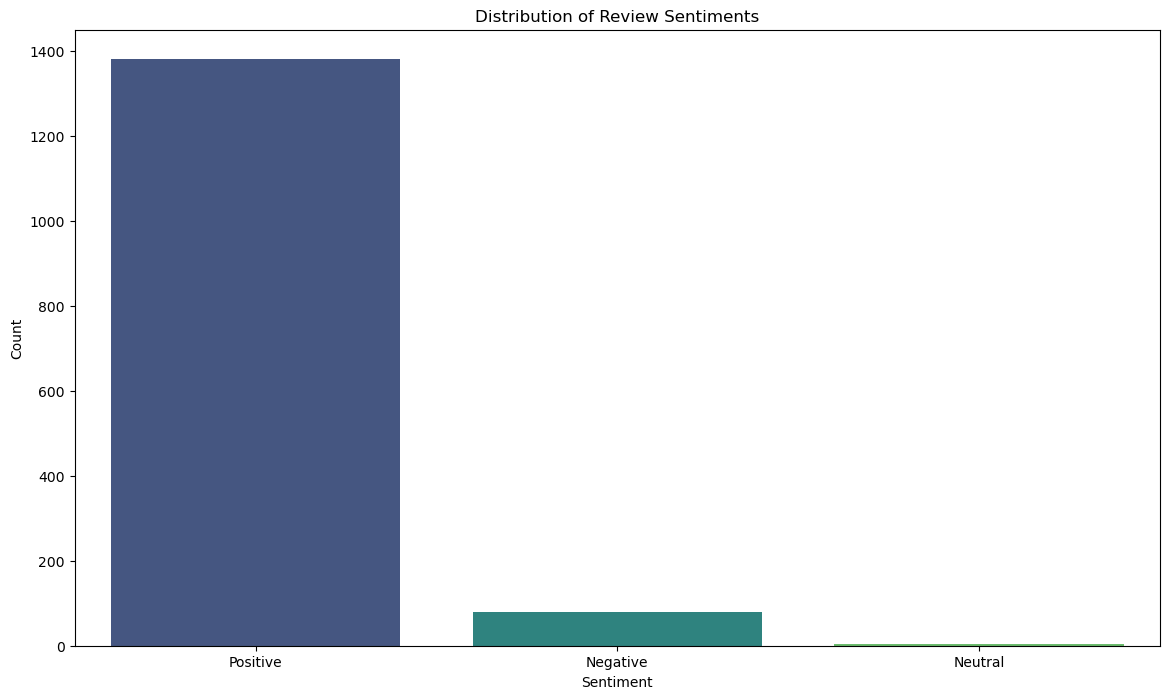

In [83]:
# Sentiment distribution
sentiment_counts = df['vader_sentiment'].value_counts()
plt.figure(figsize=(14, 8))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='viridis')
plt.title('Distribution of Review Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Summary
# - Most reviews express positive sentiment, aligning with the generally high ratings.
# - Negative sentiment reviews are relatively low, reflecting lower instances of poor product experiences.

### Summary ###
- Most reviews express positive sentiment, aligning with the generally high ratings.
- Negative sentiment reviews are relatively low, reflecting lower instances of poor product experiences.

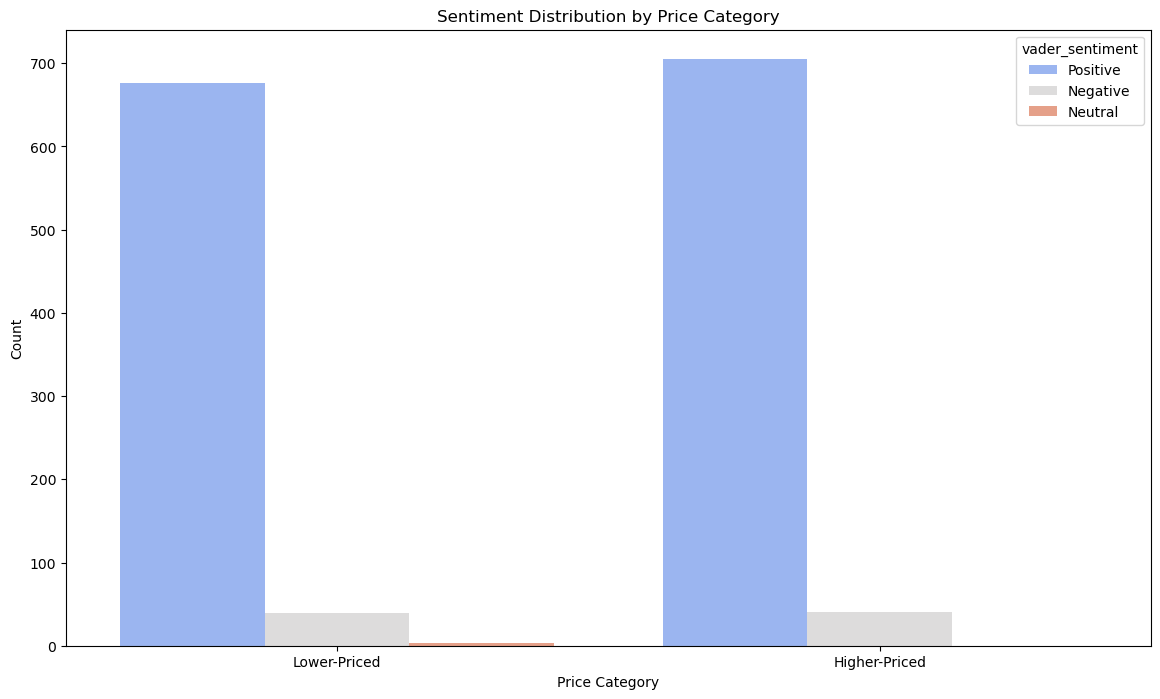

In [84]:
# Sentiment distribution by price category
plt.figure(figsize=(14, 8))
sns.countplot(x='price_category', hue='vader_sentiment', data=df, palette='coolwarm')
plt.title('Sentiment Distribution by Price Category')
plt.xlabel('Price Category')
plt.ylabel('Count')
plt.show()

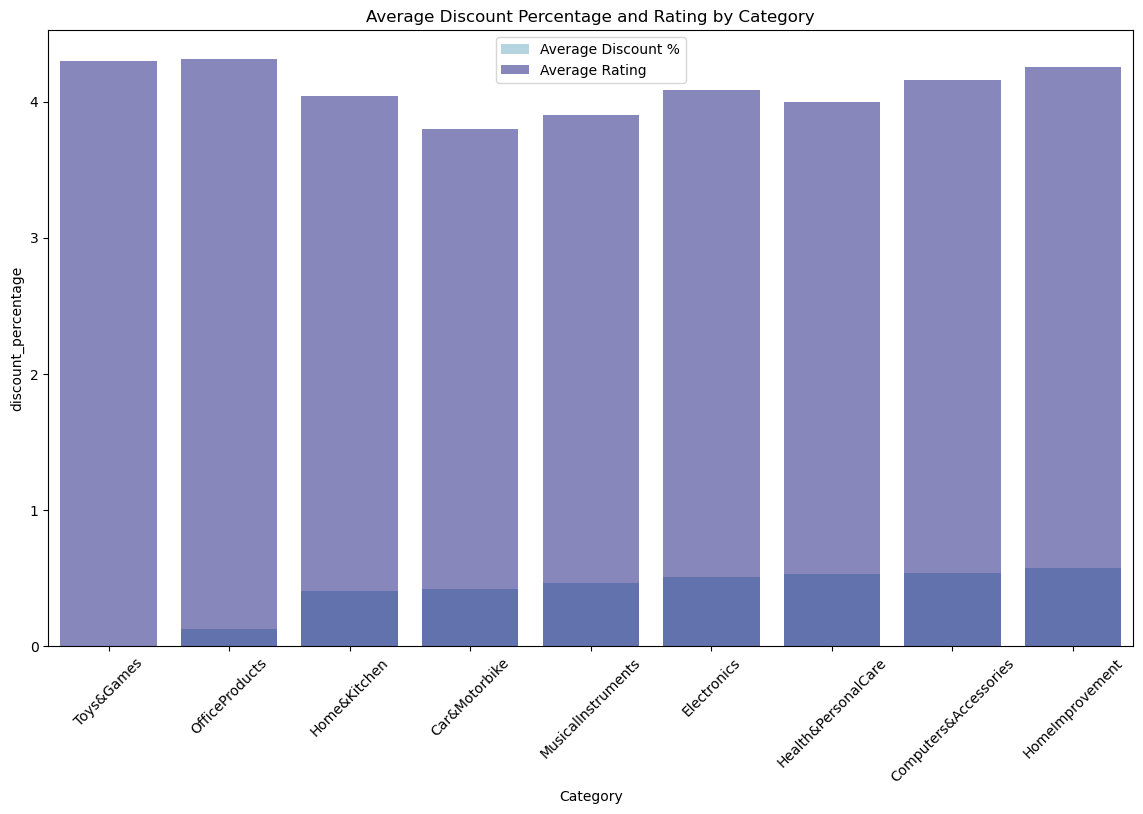

In [90]:
# Compare average discount and rating across categories
category_comparison = df.groupby('main_category').agg({'discount_percentage': 'mean', 'rating': 'mean'}).reset_index()
# Sort by discount_percentage in descending order
category_comparison = category_comparison.sort_values(by='discount_percentage')
plt.figure(figsize=(14, 8))
sns.barplot(x='main_category', y='discount_percentage', data=category_comparison, color='lightblue', label='Average Discount %')
sns.barplot(x='main_category', y='rating', data=category_comparison, alpha=0.5, color='darkblue', label='Average Rating')
plt.xticks(rotation=45)
plt.title('Average Discount Percentage and Rating by Category')
plt.xlabel('Category')
plt.legend()
plt.show()

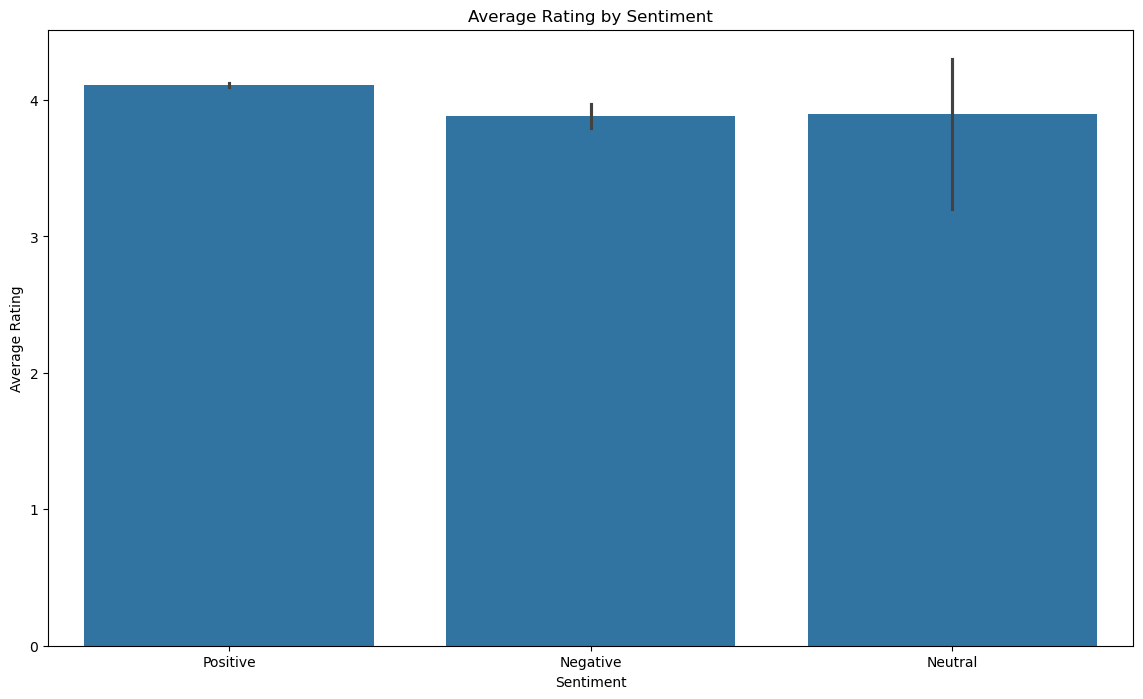

In [70]:
# Bar plot for average rating by sentiment
plt.figure(figsize=(14, 8))
sns.barplot(x='vader_sentiment', y='rating', data=df, estimator=np.mean)
plt.title('Average Rating by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Average Rating')
plt.show()

As the bar graph shows:
- Products receive more positive reviews will also receive higher ratings.
- Both neutral and negative sentiment products have fairly close average ratings, though slightly lower than positive ones.
- This shows that neutral viewers aren't significantly driving up ratings, and negative feedback doesn't drastically reduce their rating either.

In [71]:
df.groupby('vader_sentiment')['rating'].describe()

,count,mean,std,min,25%,50%,75%,max
vader_sentiment,,,,,,,,
Negative,80.0,3.881250,0.401924,2.3,3.7,3.95,4.20,4.5
Neutral,3.0,3.900000,0.608276,3.2,3.7,4.20,4.25,4.3
Positive,1381.0,4.109413,0.275757,2.0,4.0,4.10,4.30,5.0


- Positive sentiment reviews are associated with higher average ratings and slightly lower variability, suggesting that positive sentiment aligns with more consistent high ratings.
- The standard deviation of Neutral and negative are quite big (0.4 and 0.6 compared with 0.3), it shows that customers who have neutral and negative reviews tend to have wider range in rating.

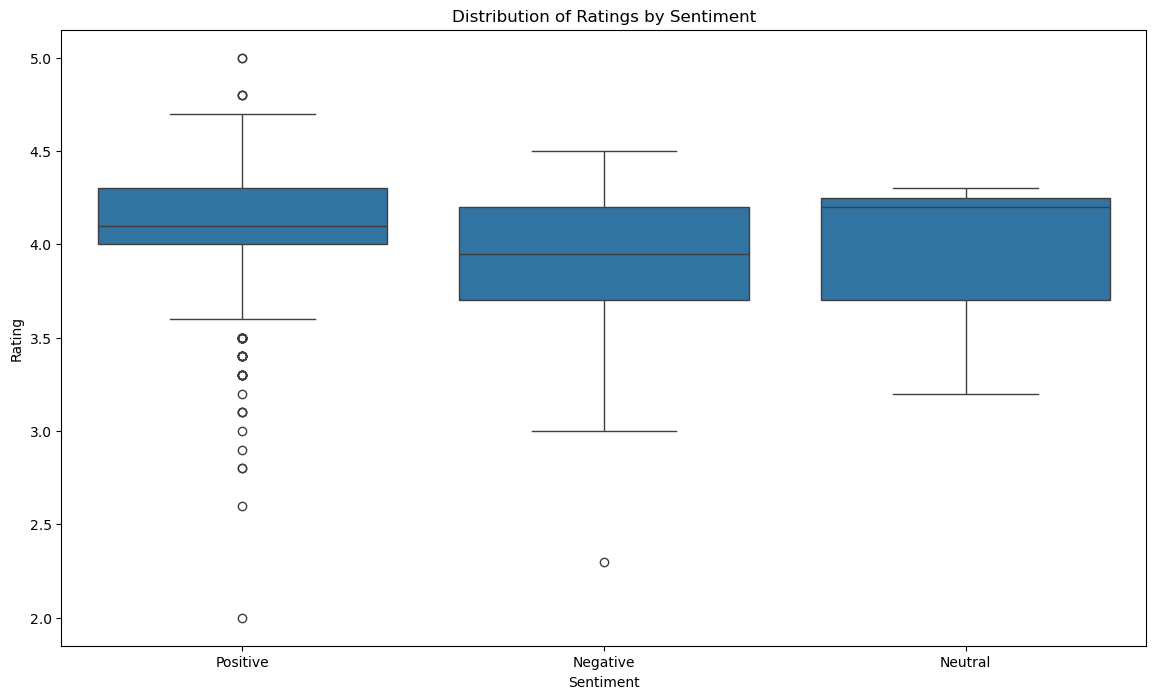

In [72]:
# Box plot to show the distribution of ratings by sentiment
plt.figure(figsize=(14, 8))
sns.boxplot(x='vader_sentiment', y='rating', data=df)
plt.title('Distribution of Ratings by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Rating')
plt.show()

- Products with positive sentiment tend to have higher ratings, but there are still some lower-rated products with positive sentiment reviews.
- Products with negative sentiment have a wider distribution of ratings, including some very low ratings, though the median is still relatively high.
- The neutral sentiment group has a consistent range of ratings, without extreme highs or lows.

In [73]:
correlation = df['vader_sentiment_score'].corr(df['rating'])
print(f"Correlation between sentiment score and rating: {correlation}")

Correlation between sentiment score and rating: 0.23757429505958585


**Reasoning**:

**Summary**: 
- Since the correlation is positive, it means that as the sentiment score increases (i.e., reviews become more positive), the product rating tends to increase as well. However, the correlation is relatively weak.
- A correlation of 0.238 suggests that while there is a relationship between sentiment and rating, it is not very strong. This means other factors may also be influencing the product ratings apart from sentiment. It's possible that even with positive sentiment, product quality, expectations, or other factors might moderate the final rating a customer leaves.

**Analysis decision **: Statistical Test: ANOVA

In [74]:
positive = df[df['vader_sentiment'] == 'Positive']['rating']
negative = df[df['vader_sentiment'] == 'Negative']['rating']
neutral = df[df['vader_sentiment'] == 'Neutral']['rating']

# Perform one-way ANOVA
anova_result = stats.f_oneway(positive, negative, neutral)
print(f"ANOVA result: {anova_result}")

ANOVA result: F_onewayResult(statistic=24.996069452954682, pvalue=2.1180786044781994e-11)


1. F-statistic (24.996):

- The F-statistic measures the variance between the groups (Positive, Negative, Neutral sentiments) compared to the variance within the groups.
- A higher F-statistic suggests that the variance between groups is significantly larger than the variance within groups, indicating that the differences in the groups are meaningful.
2. p-value (2.12e-11):

- The p-value is extremely small, much lower than the commonly used significance threshold of 0.05.
- This very low p-value indicates that the differences in ratings across the sentiment categories (Positive, Negative, and Neutral) are statistically significant.
- Therefore, we reject the null hypothesis, which states that there is no difference in ratings based on sentiment. There is a significant difference in product ratings based on the sentiment expressed in the reviews.

### Research Question 5: Which Categories of Products Receive the Highest or Lowest Ratings ?

In [75]:
df.dtypes

product_id                 object
product_name               object
discounted_price          float64
actual_price              float64
discount_percentage       float64
rating                    float64
rating_count              float64
about_product              object
review_id                  object
review_title               object
review_content             object
product_link               object
main_category              object
product_type               object
price_category             object
vader_sentiment_score     float64
vader_sentiment            object
discount_bin             category
mean_of_ratings          category
rating_count_group       category
dtype: object

In [76]:
df['main_category'].value_counts()

Electronics              526
Computers&Accessories    452
Home&Kitchen             448
OfficeProducts            31
MusicalInstruments         2
HomeImprovement            2
Toys&Games                 1
Car&Motorbike              1
Health&PersonalCare        1
Name: main_category, dtype: int64

As we can see, `MusicalInstruments`, `HomeImprovement`, `Toys&Games`, `Car&Motorbike`, `Health&PersonalCare`, `OfficeProducts` have only 1 or 2 product, so we cannot analysis based on small sample size.

In [77]:
# Count the number of products in each category
category_counts = df.groupby('main_category').size().reset_index(name='product_count')

# Filter to get only categories with 3 or more products
valid_categories = category_counts[category_counts['product_count'] >= 100]['main_category']

# Filter the original DataFrame to include only these valid categories
filtered_df = df[df['main_category'].isin(valid_categories)]

# Display the filtered DataFrame
print(filtered_df['main_category'].value_counts())

Electronics              526
Computers&Accessories    452
Home&Kitchen             448
Name: main_category, dtype: int64


Group by category_1

In [78]:
# Group by category_1 and calculate the mean rating
category_rating = filtered_df.groupby('main_category')['rating'].mean().reset_index()

# Sort by rating to see highest and lowest
category_rating = category_rating.sort_values(by='rating', ascending=False)
print(category_rating)

           main_category    rating
0  Computers&Accessories  4.155310
1            Electronics  4.081749
2           Home&Kitchen  4.040402


- All categories have relatively high ratings (above 4.0 on average)
- Computers & Accessories stands out with the highest ratings, indicating a slightly better customer perception in this category.

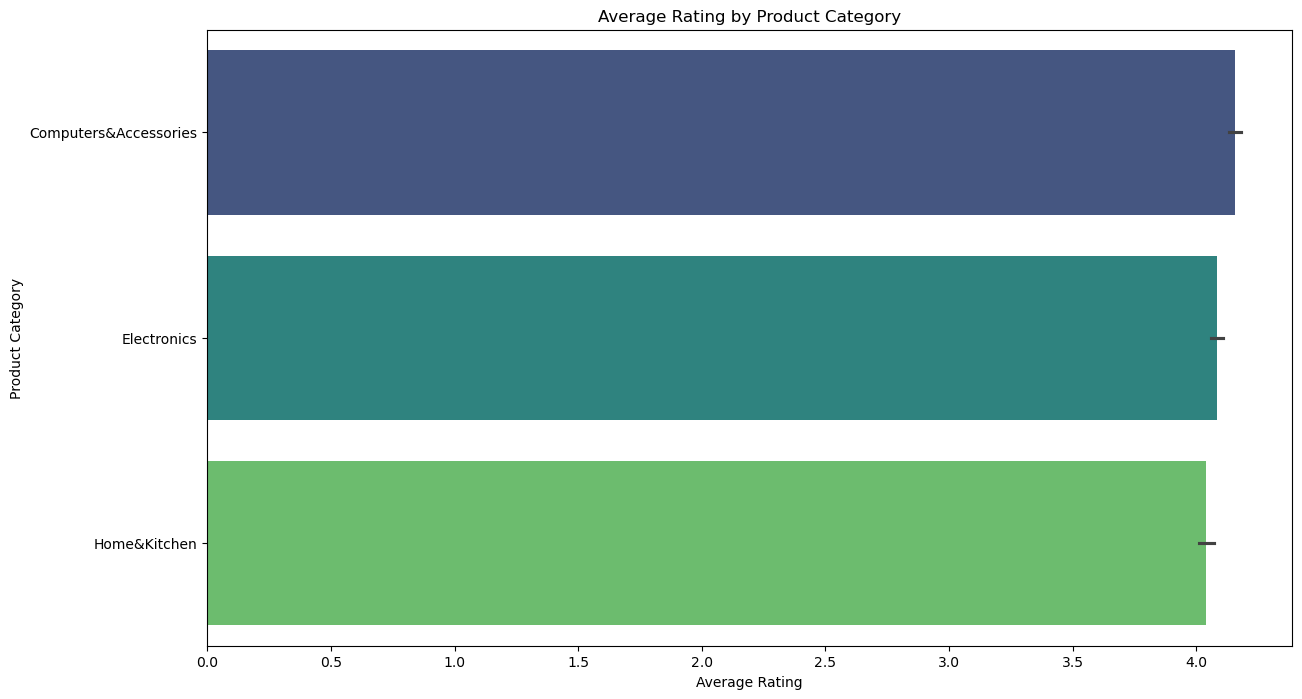

In [79]:
# Bar plot of average ratings by product category
plt.figure(figsize=(14, 8))
sns.barplot(x='rating', y='main_category', data=filtered_df, hue='main_category', palette='viridis', dodge=False, legend=False)
plt.title('Average Rating by Product Category')
plt.xlabel('Average Rating')
plt.ylabel('Product Category')
plt.show()

- All categories have average ratings above 4.0, suggesting a good level of customer satisfaction across the board.
- Computers & Accessories leads slightly in customer satisfaction, possibly reflecting better perceived quality or value in this category compared to Electronics and Home & Kitchen.

In [80]:
# Group by rating categories and calculate the correlation
grouped_by_rating_cat = filtered_df.groupby(['main_category','mean_of_ratings']).apply(
    lambda x: x['discount_percentage'].corr(x['rating']) if len(x) > 1 else None
)

print(grouped_by_rating_cat)

main_category          mean_of_ratings
Computers&Accessories  Average           -0.209750
                       Good               0.164417
                       Excellent         -0.231080
Electronics            Low               -0.842989
                       Average           -0.052182
                       Good              -0.217358
                       Excellent          0.022300
Home&Kitchen           Low                0.594894
                       Average           -0.108601
                       Good              -0.157715
                       Excellent          0.019532
dtype: float64


**Summary**: 
- Electronics with low ratings show the strongest negative correlation (-0.842989), it shows that higher discounts are more common for lower-rated electronics.
- Home & Kitchen Low-rated products (0.594894) and Computers & Accessories good-rated products (0.164417) show positive correlations, suggesting that discounts may be associated with better ratings in certain contexts within these categories.
- Across all categories, the correlation between discounts and ratings is minimal for "Excellent" rated products, implying that discounts don’t significantly impact ratings for highly-rated items

# <a id='conclusions'></a>
## Conclusions


1. Is there a relationship between discount percentage and average product rating ?
- The relationship is weak negative between discount percentage and average product rating.
- Lower-rated products often have higher discount, while higher-rate products seem not have significantly impact.
2. Do products with more reviews have higher or lower average ratings?
- There is a weak positive relationship between the number of reviews and average product ratings. Products with more reviews tend to have slightly higher ratings, but the effect is small.
- Products with more reviews tend to have tighter rating distributions, suggesting that increased visibility may lead to more consistent ratings, potentially due to a larger and more diverse customer base.
- Higher review counts have a stronger positive impact on lower-rated products, potentially helping improve their ratings slightly. However, for "Excellent" rated products, the effect of additional reviews on rating is minimal or even slightly negative.
3. Do higher-priced products receive better ratings than lower-priced ones?
- Higher-priced products receive better ratings than lower-priced products, but the difference is minimal, indicating that price alone is not a major determinant of product rating.
- Higher-priced products show slightly more consistent ratings (lower standard deviation), suggesting that customers may have more stable expectations for higher-priced items.
- The weak positive correlation between price and rating within both groups implies that customers slightly favor higher-priced products, but this effect is minor and likely influenced by other factors such as product quality or brand reputation.
4. Do Products with Positive Sentiment in Reviews Have Higher Ratings?
- Products with positive sentiment in reviews tend to have higher ratings compared to those with neutral or negative sentiment, confirming that sentiment is a useful indicator of product rating.
- The ANOVA test confirms that these differences are statistically significant, suggesting that the sentiment expressed in reviews is a meaningful predictor of product rating.
- For businesses, encouraging positive customer sentiment in reviews can positively impact product ratings. This highlights the importance of customer satisfaction and quality in maintaining high ratings.
5. Which Categories of Products Receive the Highest or Lowest Ratings?
- Computers & Accessories has the highest average rating (4.16), suggesting that this category generally has a higher level of customer satisfaction.
- Home & Kitchen has the lowest average rating among the analyzed categories, though the difference is minimal, indicating that all three categories generally receive favorable ratings.
- In Electronics and Computers & Accessories, lower-rated products tend to have higher discounts, which may indicate a strategy to boost sales or attractiveness despite lower customer satisfaction.
- Home & Kitchen shows a unique pattern where low-rated products actually benefit in ratings with higher discounts, as indicated by the positive correlation for Low ratings.

<a id='limit'></a>
## Limitation

- This source might not represent a comprehensive and unbiased sample of all movies. It is possible that some genres of movies are not represented.
- The correlation does not imply causation. It will need more experiments and statistical analyses. The findings in this analysis provide associations but should not be interpreted as causal relationships.

In [81]:
from subprocess import run
result = run(['python', '-m', 'nbconvert', '--to', 'html', 'Investigate_a_Dataset.ipynb'])
print("Conversion successful!" if result.returncode == 0 else "Conversion failed.")

[NbConvertApp] Converting notebook Investigate_a_Dataset.ipynb to html
[NbConvertApp] Writing 1450531 bytes to Investigate_a_Dataset.html


Conversion successful!
